In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiteshbhatnagar","key":"e201a58ba519471d1d6c10af03d3d68e"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

#!/bin/bash
!kaggle datasets download grassknoted/asl-alphabet


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 99% 1.01G/1.03G [00:05<00:00, 210MB/s]
100% 1.03G/1.03G [00:05<00:00, 195MB/s]


In [4]:
# Unzip the dataset into a folder
!unzip /content/asl-alphabet.zip -d /content/asl_dataset

# Check the directory structure
import os
os.listdir('/content/asl_dataset')


Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_trai

['asl_alphabet_train', 'asl_alphabet_test']

In [5]:
ls asl_dataset/asl_alphabet_test/asl_alphabet_test

A_test.jpg  E_test.jpg  I_test.jpg  M_test.jpg        P_test.jpg      S_test.jpg  W_test.jpg
B_test.jpg  F_test.jpg  J_test.jpg  nothing_test.jpg  Q_test.jpg      T_test.jpg  X_test.jpg
C_test.jpg  G_test.jpg  K_test.jpg  N_test.jpg        R_test.jpg      U_test.jpg  Y_test.jpg
D_test.jpg  H_test.jpg  L_test.jpg  O_test.jpg        space_test.jpg  V_test.jpg  Z_test.jpg


In [6]:
ls asl_dataset/asl_alphabet_train/asl_alphabet_train

A/  C/  del/  F/  H/  J/  L/  N/        O/  Q/  S/      T/  V/  X/  Z/
B/  D/  E/    G/  I/  K/  M/  nothing/  P/  R/  space/  U/  W/  Y/


In [7]:
# Paths
train_dir = '/content/asl_dataset/asl_alphabet_train/asl_alphabet_train'
test_dir = '/content/asl_dataset/asl_alphabet_test/asl_alphabet_test'

# Define batch size and image size
batch_size = 32
img_size = (64, 64)

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

labels = list(train_generator.class_indices.keys())
print("Class Labels:", labels)


Found 87000 images belonging to 29 classes.
Found 87000 images belonging to 29 classes.
Class Labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [8]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(len(labels), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [9]:

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=7,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/7
2719/2719 [==============================] - 573s 210ms/step - loss: 1.1509 - accuracy: 0.6490 - val_loss: 0.7366 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 2/7
2719/2719 [==============================] - 559s 206ms/step - loss: 0.7757 - accuracy: 0.7506 - val_loss: 0.6248 - val_accuracy: 0.7990 - lr: 0.0010
Epoch 3/7
2719/2719 [==============================] - 558s 205ms/step - loss: 0.6730 - accuracy: 0.7834 - val_loss: 0.6082 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 4/7
2719/2719 [==============================] - 557s 205ms/step - loss: 0.6188 - accuracy: 0.7989 - val_loss: 0.6173 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 5/7
2719/2719 [==============================] - 557s 205ms/step - loss: 0.5842 - accuracy: 0.8102 - val_loss: 0.5859 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 6/7
2719/2719 [==============================] - 566s 208ms/step - loss: 0.5595 - accuracy: 0.8178 - val_loss: 0.5089 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 7/7
2719/2719 [===================

2719/2719 [==============================] - 266s 97ms/step


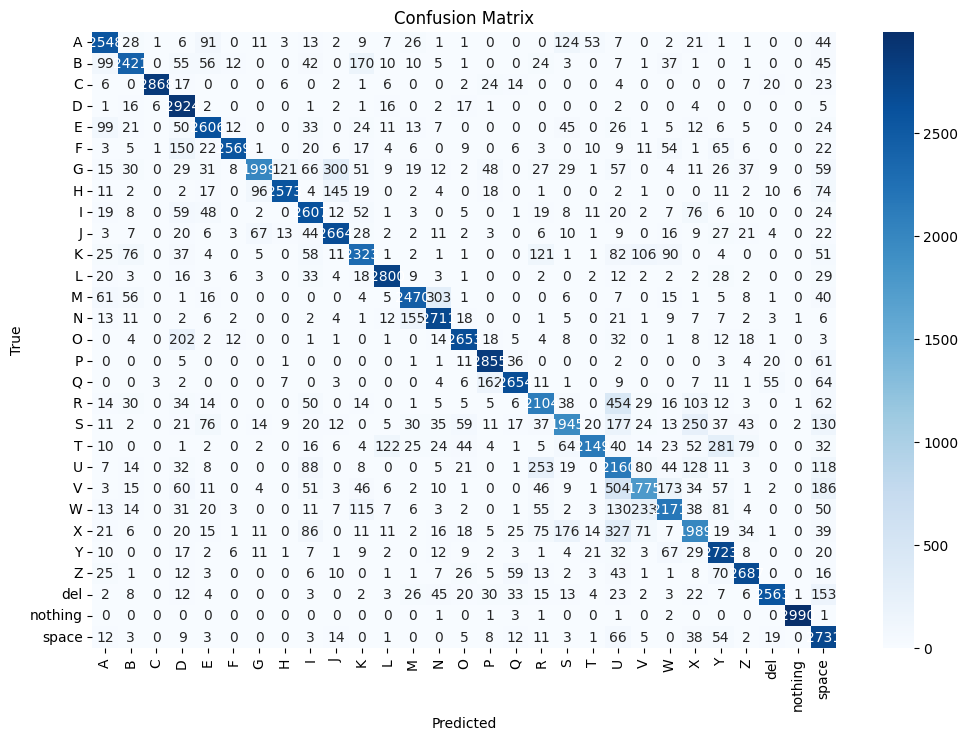

Classification Report:

              precision    recall  f1-score   support

           A       0.84      0.85      0.84      3000
           B       0.87      0.81      0.84      3000
           C       1.00      0.96      0.98      3000
           D       0.76      0.97      0.86      3000
           E       0.85      0.87      0.86      3000
           F       0.98      0.86      0.91      3000
           G       0.90      0.67      0.77      3000
           H       0.94      0.86      0.90      3000
           I       0.80      0.87      0.83      3000
           J       0.83      0.89      0.86      3000
           K       0.79      0.77      0.78      3000
           L       0.92      0.93      0.93      3000
           M       0.88      0.82      0.85      3000
           N       0.84      0.90      0.87      3000
           O       0.90      0.88      0.89      3000
           P       0.89      0.95      0.92      3000
           Q       0.92      0.88      0.90      3000
   

In [10]:
# Predict on Test Data
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


In [11]:
model.save("sign_recognition_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Convert the saved model to Tensorflow lite

In [12]:
import tensorflow as tf

model = tf.keras.models.load_model("sign_recognition_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('sign_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)